---
# 📈 Quantitative analysis of endocytosis.

Note: Demo data used in this notebook is not included in the repository, but can be made available upon request.

In [ ]:
## requirements
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import roux.lib.df as rd 
from roux.lib.io import read_dict, to_dict, read_table, to_table
from roux.viz.io import to_plot

from htsimaging.lib.io import read_image
from htsimaging.viz.image import image_background,image_regions_annotated

In [2]:
## input parameters
input_dir_path='endocytosis/input/' # contains subfolders for each set of images
output_dir_path='endocytosis/output/'
segmented_fn_marker='segment' # the marker in the file name to identify the segmented image
image_ext='npy'
magnification=100

test=True
force=True

## Configuration of the input images

[2023-08-10 13:24:55,186] INFO	from io.py in make_project_cfg(..): making cfg
[2023-08-10 13:24:55,424] INFO	from 862036698.py in <module>(..): The information stored in the configuration: dict_keys(['prjd', 'outd', 'cfgp', 'cores', 'bright_fn_marker', 'segmented_fn_marker', 'magnification', 'trials'])


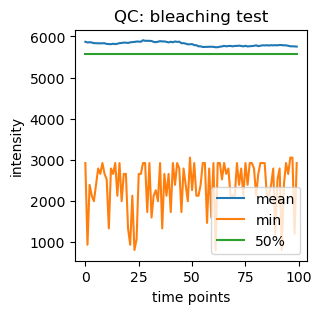

In [3]:
from htsimaging.endocytosis.io import make_project_cfg
cfg=make_project_cfg(
    prjd=input_dir_path,
    output_dir_path=output_dir_path,
    segmented_fn_marker=segmented_fn_marker,
    magnification=magnification,
    image_ext=image_ext,
    # cores=cores,
    test=test,
    force=force
)
logging.info(f"The information stored in the configuration: {cfg.keys()}")

In [4]:
## Note: for the demo one of the sets of images are selected
trial=list(cfg['trials'])[0]

## Separation to single-cell images

### Labeling of the cells

In [5]:
## annotate
assert len(cfg['trials'][trial]['segmented'])==1, f"Expected one segmented image, found {cfg['trials'][trial]['segmented']}"
image_segmented_path=cfg['trials'][trial]['segmented'][0]
from skimage import measure
regions=measure.label(read_image(image_segmented_path))
if len(np.unique(regions))==1:
    logging.error("the output does not contain any regions")
## save
cfg['trials'][trial]['bright_segmented_cells']=f"{cfg['trials'][trial]['outd']}/segmented_labeled.npy" 
np.save(cfg['trials'][trial]['bright_segmented_cells'], regions)

[2023-08-10 13:24:55,655] WARNING	from io.py in savefig(..): overwritting: endocytosis/output//images01//plot/image_segmented_labeled.png


'/mnt/d/Documents/code/htsimaging/examples/endocytosis/output/images01/plot/image_segmented_labeled.png'

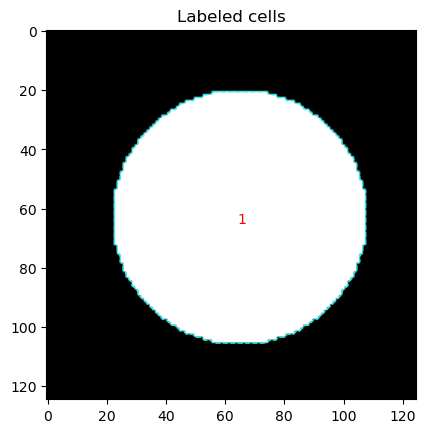

In [6]:
## plot
image_regions_annotated(img=read_image(image_segmented_path),img_region=regions,show_cbar=False).set(title='Labeled cells')
to_plot(f"{cfg['trials'][trial]['plotd']}/image_segmented_labeled.png")

### Filtering by properties

In [7]:
## average intensity of the gfp images
frames = [read_image(p) for p in sorted(cfg['trials'][trial]['gfp'])]
intensity_image=np.mean(frames,axis=0)

'/mnt/d/Documents/code/htsimaging/examples/endocytosis/output/images01/plot/image_average_intensity.png'

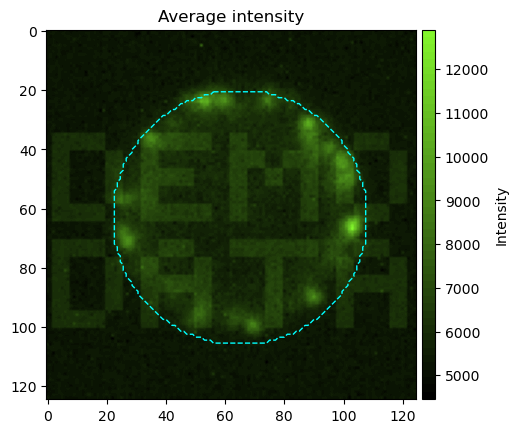

In [8]:
## plot
image_background(img=intensity_image,img_region=regions, cmap='gfp').set(title='Average intensity')
to_plot(f"{cfg['trials'][trial]['plotd']}/image_average_intensity.png")

In [9]:
## properties
from skimage.measure import regionprops_table
props=regionprops_table(
    label_image=regions.astype(int),
    intensity_image=intensity_image,
    properties=[
        'label',
        'bbox',
        'area',
        'bbox_area',
        'convex_area',
        'eccentricity',
        'equivalent_diameter',
        'euler_number',
        'extent',
        'filled_area',
        'label',
        'major_axis_length',
        'max_intensity',
        'mean_intensity',
        'min_intensity',
        'minor_axis_length',
        'orientation',
        'perimeter',
        'solidity',
        'centroid',
    ], 
    )
df1=(pd.DataFrame(props)
    .rename(
        columns={
        "label":"cell #",
         'bbox-0':"xmin",
         "bbox-1":"ymin",
         "bbox-2":"xmax",
         "bbox-3":"ymax",
        },
        errors='raise'
    ))
to_table(
    df1,
    f"{cfg['trials'][trial]['bright_segmented_cells']}.cellprops.tsv",
    )
df1.head(1)

,cell #,xmin,ymin,xmax,ymax,area,bbox_area,convex_area,eccentricity,equivalent_diameter,...,major_axis_length,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,centroid-0,centroid-1
0,1,21,23,106,108,5785,7225,5833,0.0,85.823603,...,85.823932,12907.49,6445.637538,4945.13,85.823932,0.785398,279.764502,0.991771,63.0,65.0


In [10]:
### filter by the properties
df2=(df1
    ## remove the cells at the border
    ## remove irregularly shaped cells and anomalies
    ### settings optimized for yeast cells
    .log.query(expr="`eccentricity` >= 0 & `eccentricity` <= 0.8") 
    ## Optional: filter by area and other properties
    )
to_table(
    df2,
    f"{cfg['trials'][trial]['bright_segmented_cells']}.cellprops_filtered.tsv",
    )
df2.head(1)

,cell #,xmin,ymin,xmax,ymax,area,bbox_area,convex_area,eccentricity,equivalent_diameter,...,major_axis_length,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,centroid-0,centroid-1
0,1,21,23,106,108,5785,7225,5833,0.0,85.823603,...,85.823932,12907.49,6445.637538,4945.13,85.823932,0.785398,279.764502,0.991771,63.0,65.0


'/mnt/d/Documents/code/htsimaging/examples/endocytosis/input/cfg.yml'

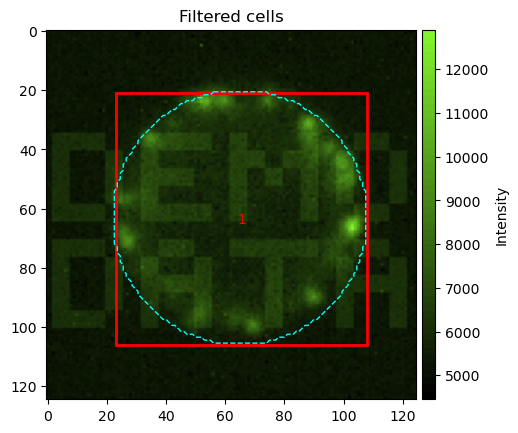

In [11]:
## plot
plt.figure()
from htsimaging.viz.image import image_regions_annotated
image_regions_annotated(
    img_region=regions.astype(int),
    img=intensity_image,
    show_boxes=True,
    cmap='gfp',
    ).set(title="Filtered cells")
plt.savefig(f"{cfg['trials'][trial]['plotd']}/image_get_cellboxes.png")
to_dict(cfg,cfg['cfgp'])

### Single-cell level configurations

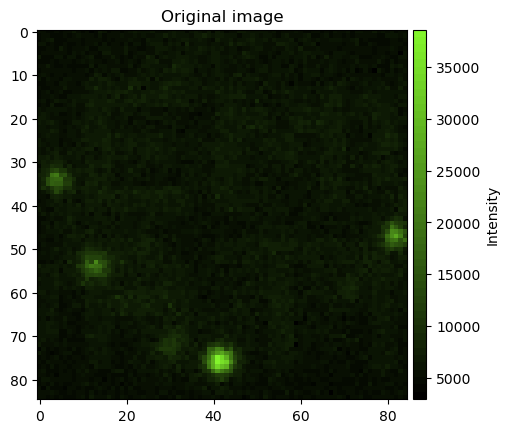

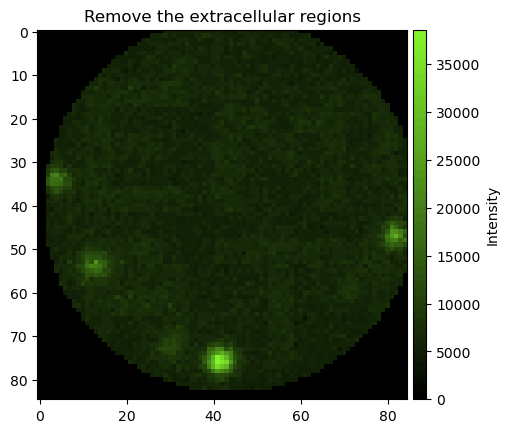

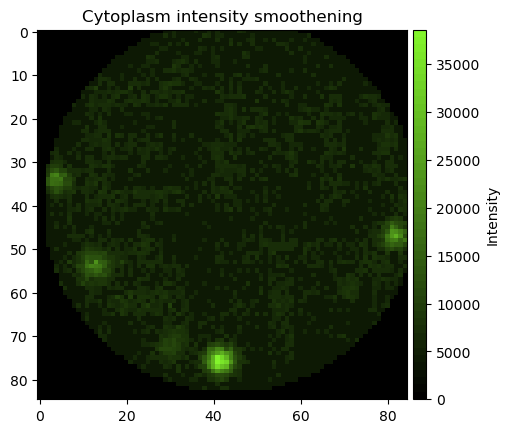

In [12]:
from htsimaging.segment.region import get_cellboxes
from htsimaging.lib.utils import get_cellprops
from htsimaging.lib.io import read_image
import pandas as pd
from htsimaging.endocytosis.io import make_cell_cfg
cellcfgps=[]
for _,x in df2.iterrows():
    celli=int(x['cell #'])
    logging.info(f"{trial};cell{celli:08d}")
    # make cg for cell
    cellcfg=make_cell_cfg(
        cfg,
        frames=frames,
        cells=regions,
        trial=trial,
        celli=celli,
        cellbox=list(map(int,[x['xmin'],x['xmax'],x['ymin'],x['ymax']])),
        test=test,
        force=force,
    )
    cellcfgps.append(cellcfg['cfgp'])

In [13]:
cfg['cellcfgps']=cellcfgps        
to_dict(cfg,f"{cfg['outd']}/cfg.yaml")

'endocytosis/output//cfg.yaml'

In [14]:
## Note: for the demo, one of the cells is selected
cellcfgp=cellcfg['cfgp']
cellcfgp

'endocytosis/output//images01//cells/cell00000001//cfg.yml'

## Single Particle Tracking (SPT) and distance calculations

In [15]:
cellcfg=read_dict(cellcfgp)
logging.info(f"The information stored in the configuration: {cellcfg.keys()}")

/home/rdandage/anaconda3/envs/htsimaging_dev/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/mnt/d/Documents/code/htsimaging/htsimaging/spt/viz.py:257: UserWarning: Attempting to set identical bottom == top == 46.714018496240115 results in singular transformations; automatically expanding.
  ax.set_ylim(df[coly].min(),df[coly].max())
/mnt/d/Documents/code/htsimaging/htsimaging/spt/viz.py:257: UserWarning: Attempting to set identical bottom == top == 16.60044541172516 results in singular transformations; automatically expanding.
  ax.set_ylim(df[coly].min(),df[coly].max())
/mnt/d/Documents/code/htsimaging/htsimaging/spt/viz.py:257: UserWarning

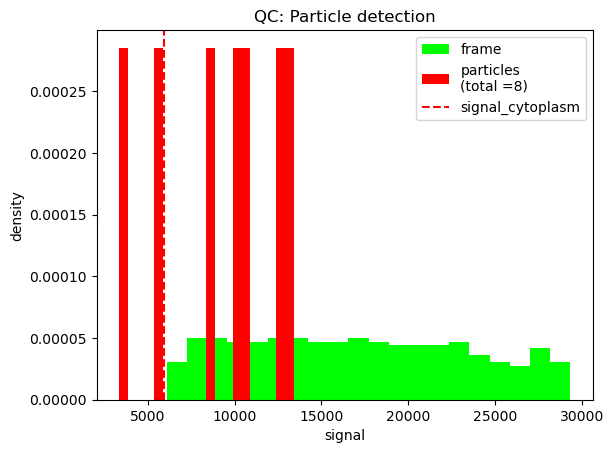

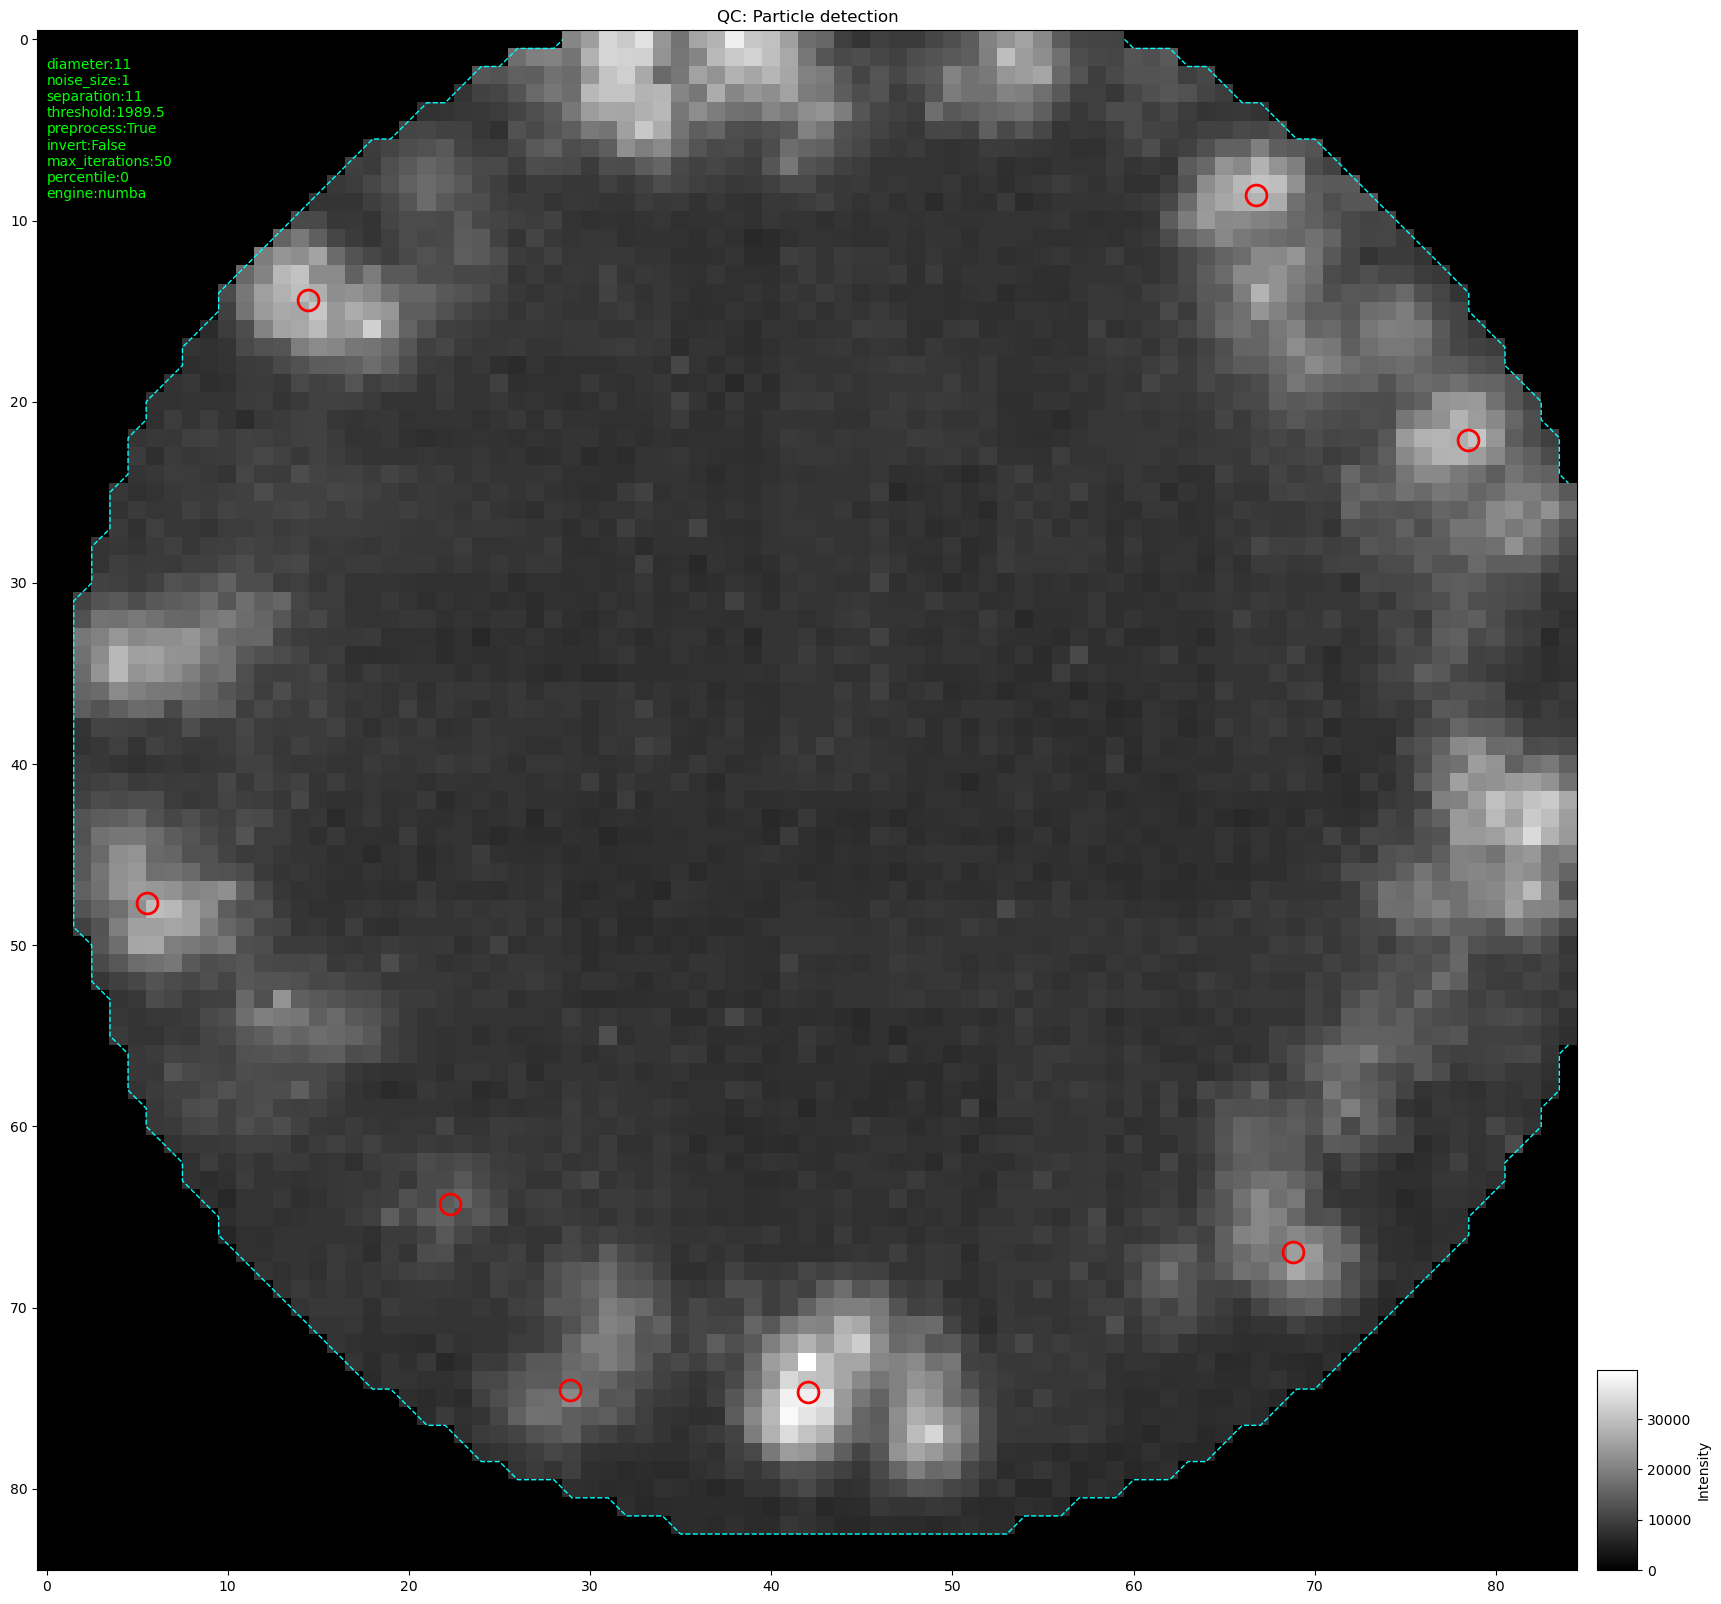

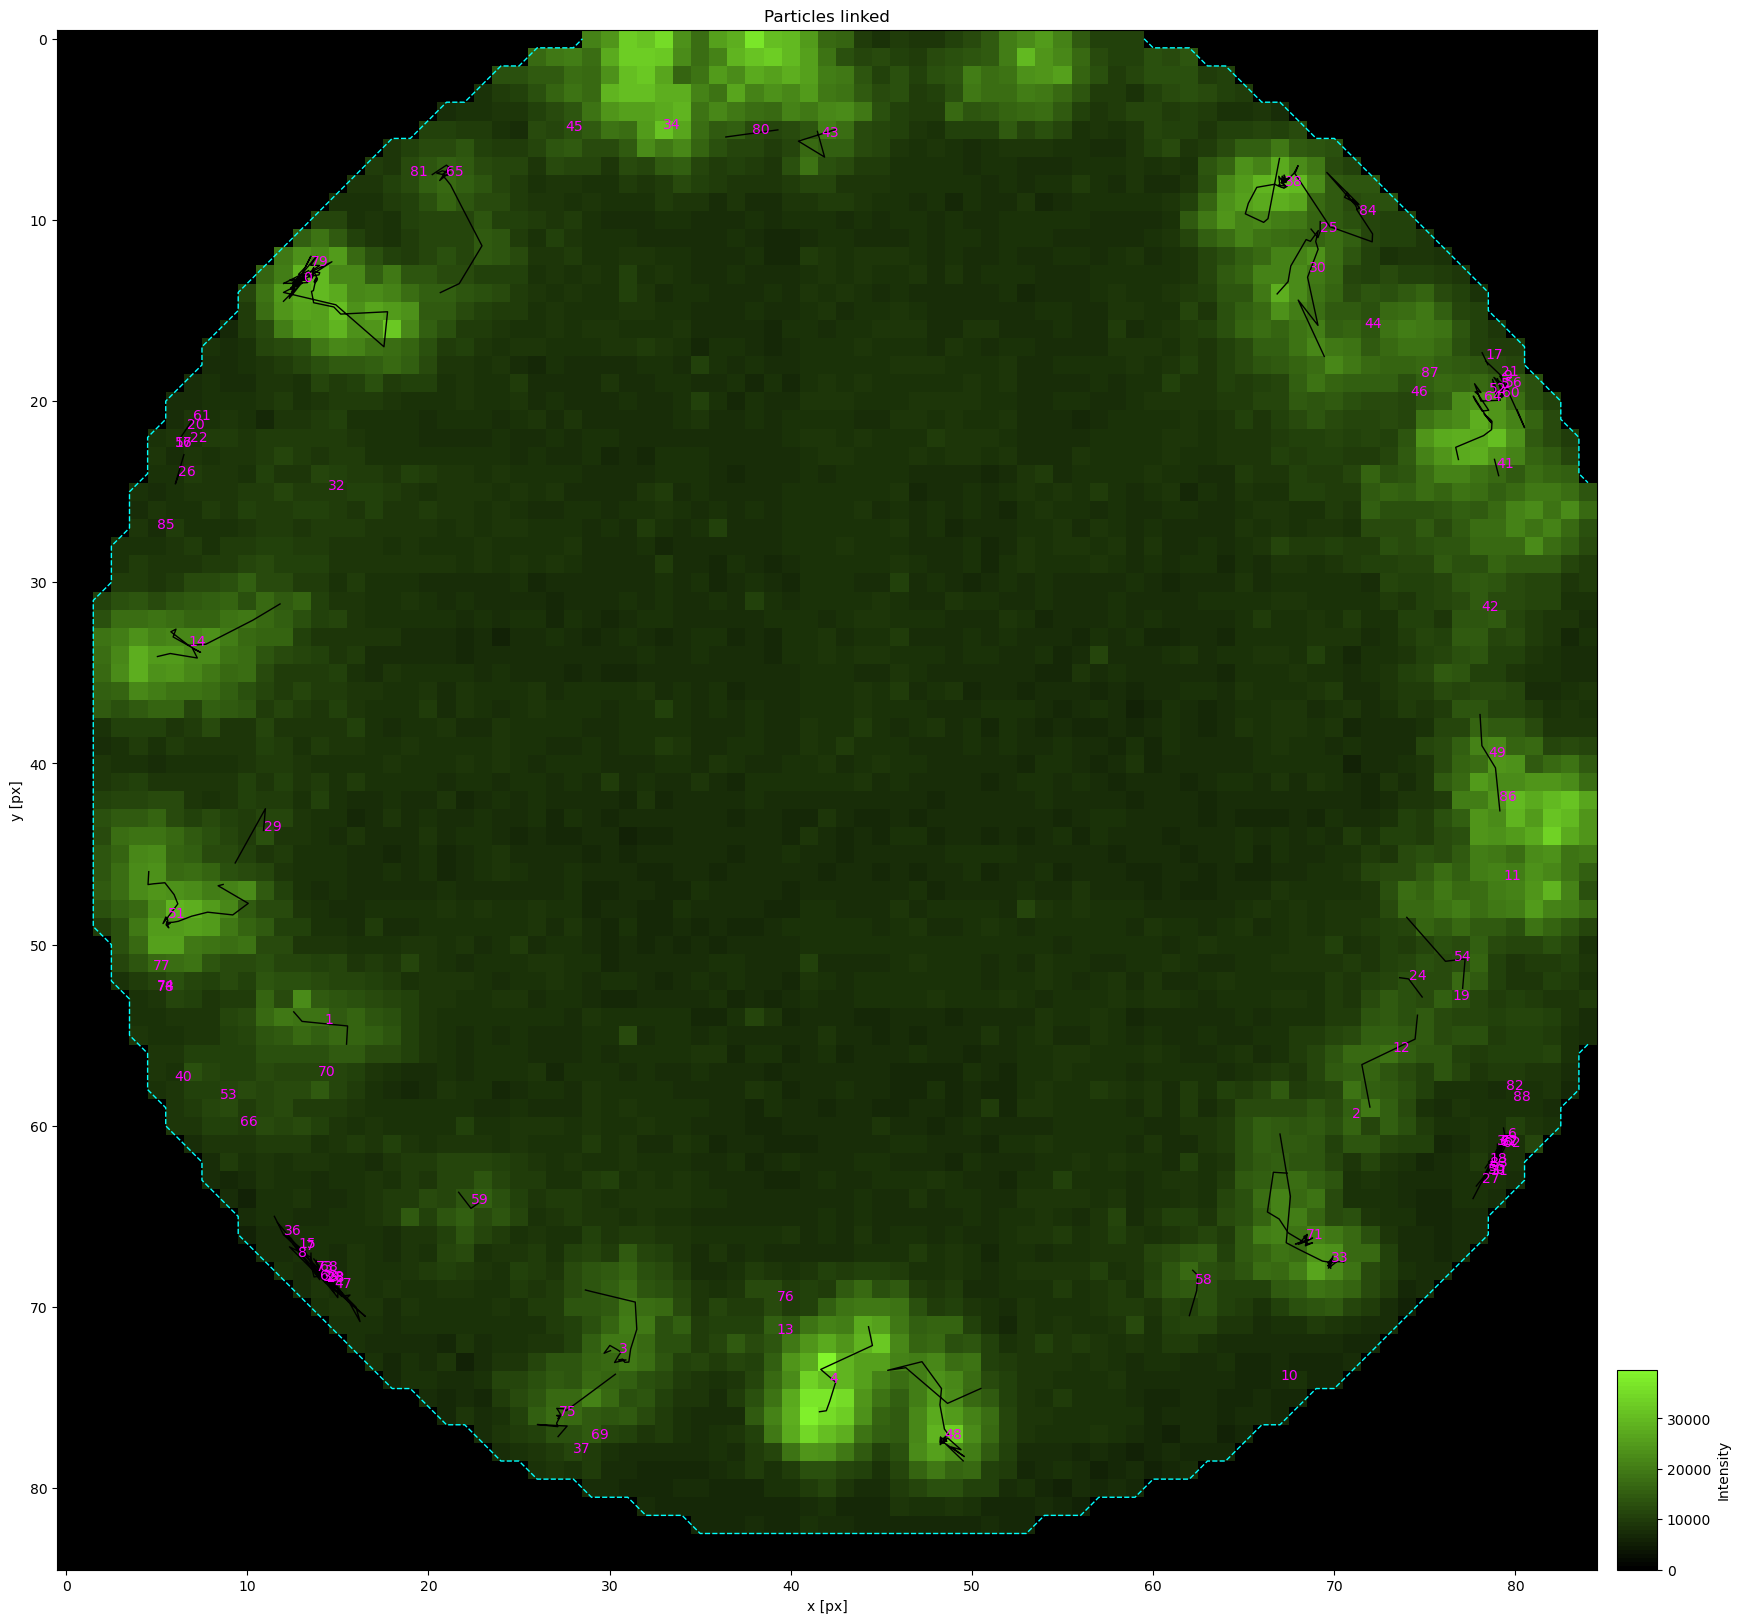

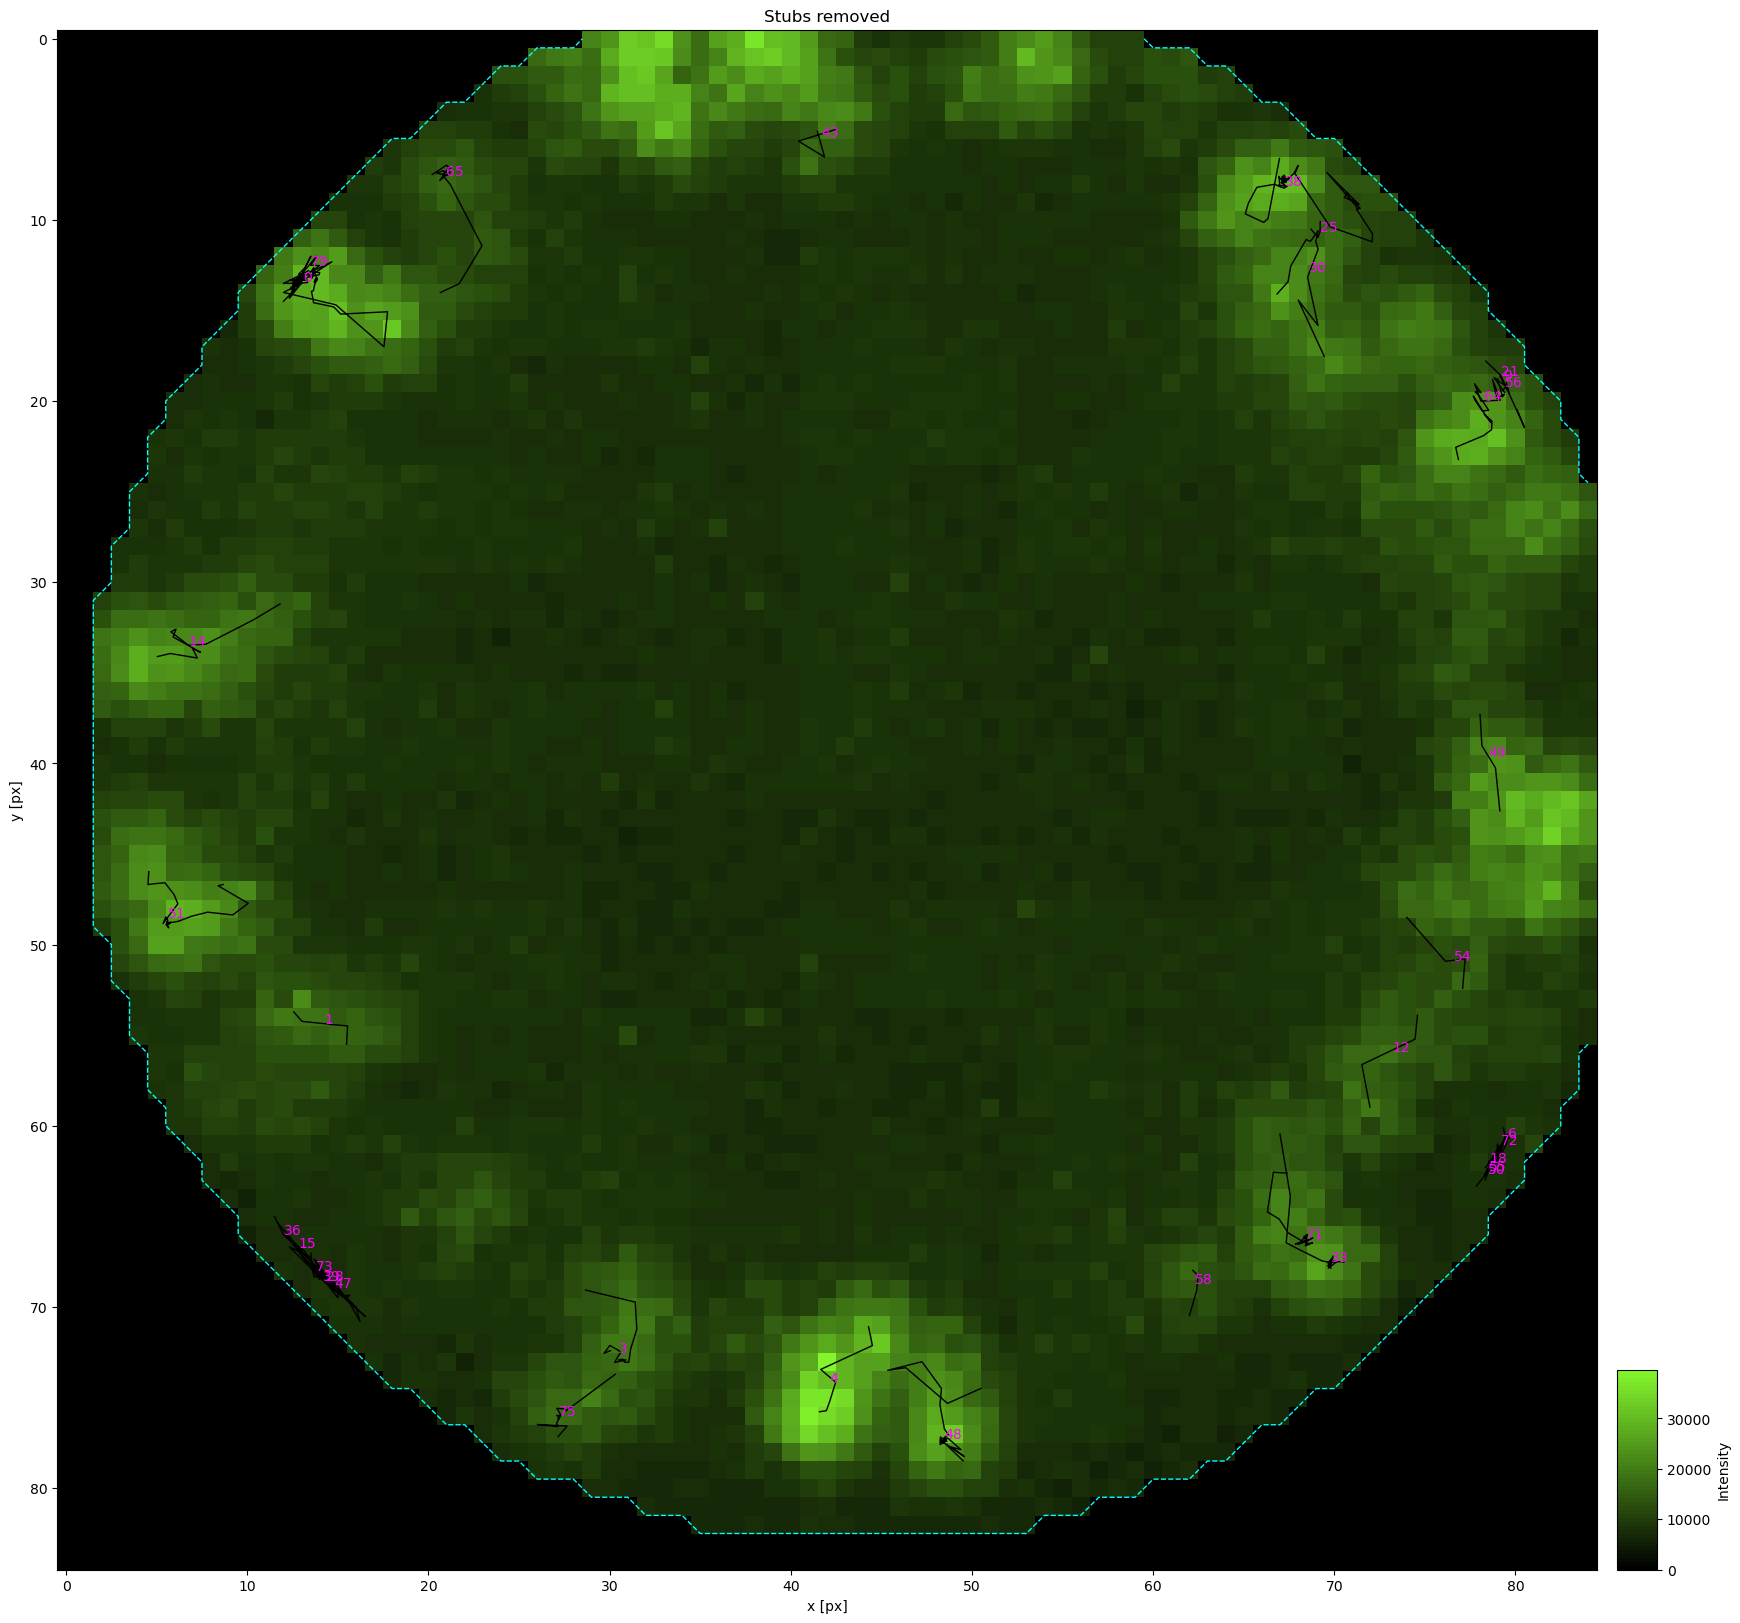

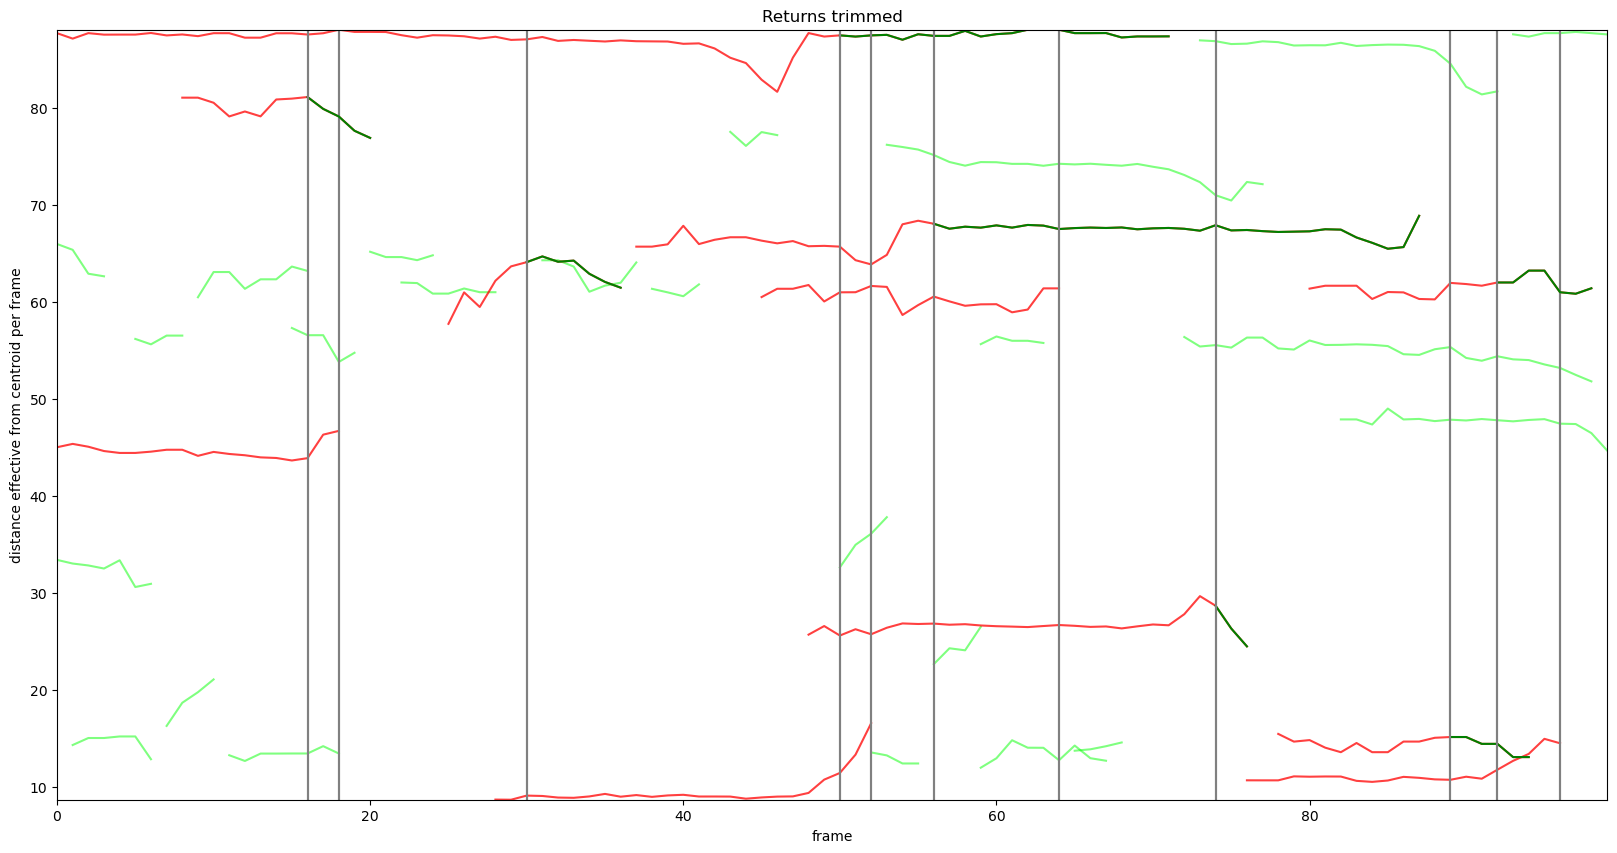

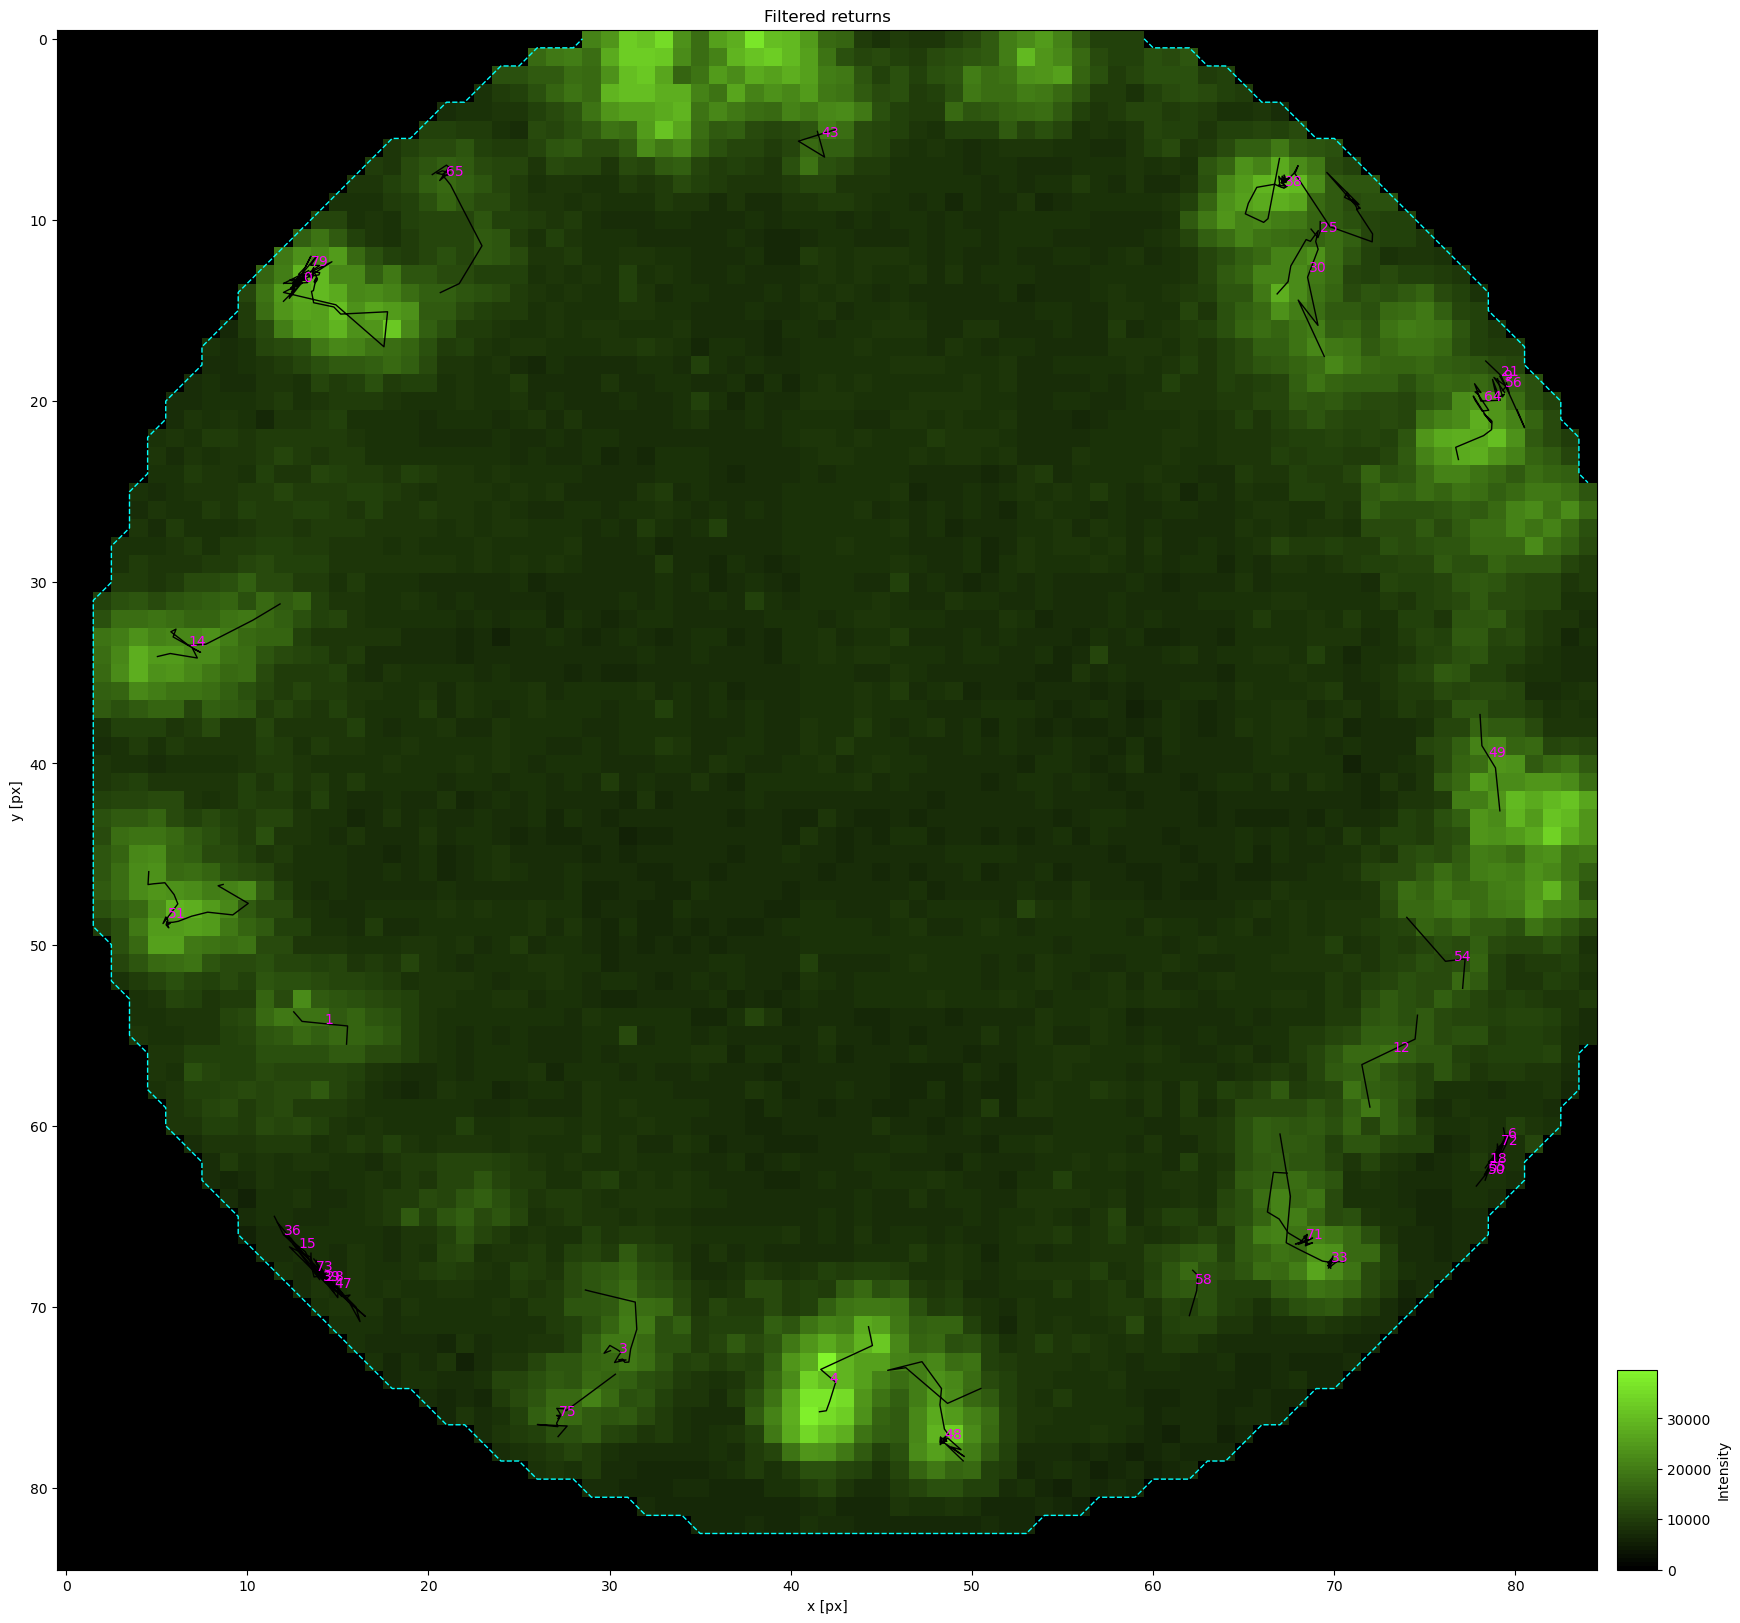

In [16]:
from htsimaging.spt.stat import cellcfg2distances
cellcfg2distances(
    cellcfg=cellcfg,
    params={ # optimized settings by step in the analysis
        'locate':{
            'diameter':11, # round to odd number
            'noise_size':1,
            'separation':15,
            'threshold':4000,
            'preprocess':True,
            'invert':False,
            'max_iterations':50,
            'percentile':0,
            'engine':'numba',
            },
        'link_df':{
            'search_range':5,
            'memory':1,
            'link_strategy':'drop',},
        'filter_stubs':{'threshold':4},
        'get_distance_from_centroid':{'center':[75,75]},
    #                     'msd':{'mpp':0.0645,'fps':0.2, 'max_lagtime':100},
               },
    subtract_drift=False,
    force=force,
    )

### Distances travelled by the particles

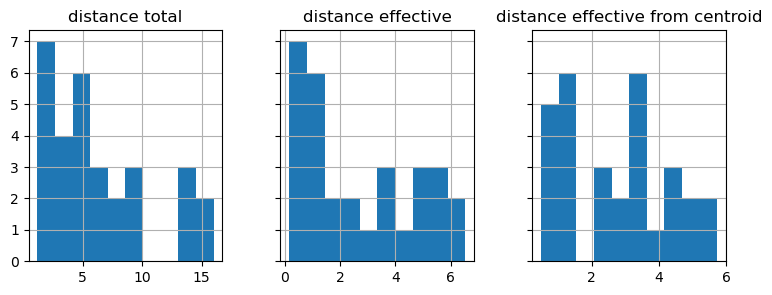

In [36]:
data=read_table(cellcfg['outp']+'d5distance.tsv')
_=data.loc[:,['particle','distance total','distance effective','distance effective from centroid',]].drop_duplicates().set_index('particle').hist(layout = (1, 3),sharey=True,figsize=[9,3])